In [1]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150

/var/folders/77/jfwlc7mn17nftm69gps4bk640000gn/T/ipykernel_84154/1719089161.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [47]:
"""Settings."""
d = 500 # dimension
k = 4 # sparsity
n = 1200 # sample size
K = 400 # number of subgroups
p = 0.1 # corruption probability
mu = np.zeros(d)
mu_sparse = [20, -10, -5, 2]
mu[:k] = mu_sparse
mu = mu.reshape((d, 1))
trial_num = 5
eta = 0.05
rho = 1
max_iter = 600
pred_5 = np.zeros((trial_num, max_iter, d, 1))

In [48]:
"""GD."""
for trial in range(trial_num):
    # initialize the dataset
    X = np.random.normal(0, 1, size=(n, d))
    # X = np.empty((n, d))
    # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean

    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        X[j, :] = 20 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50

    # Grouping preprocessing
    X_grouped = np.split(X, K)
    X_grouped = np.mean(X_grouped, axis=1)

    # initialize the parameters
    alpha = 1e-3
    u = alpha * np.ones((d, 1))
    v = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
            grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
        u -= eta * grad_u / K
        v -= eta * grad_v / K
        eta *= rho
        dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
        error[t] = abs(u * u - v * v - mu)
        pred[t] = abs(u * u - v * v)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

(5, 600, 500, 1)
(500, 600, 5, 1)


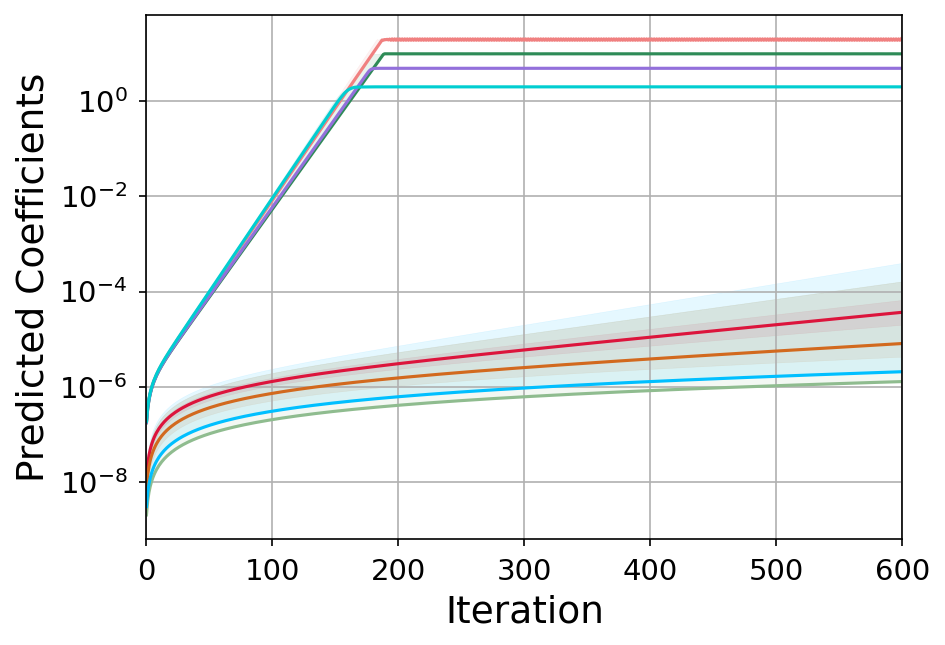

In [49]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(point_num):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[1]
        med[i][t] = sorted[2]
        maxs[i][t] = sorted[4]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i], alpha=0.1)
    plt.plot(med[i], color=col[i], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, 600)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

plt.savefig(f'figs/prediction.pdf')
plt.show()

In [50]:
"""Single-variable GD."""
pred_5 = np.zeros((trial_num, max_iter, d, 1))
for trial in range(trial_num):
    # initialize the dataset
    X = np.random.normal(0, 1, size=(n, d))
    # X = np.empty((n, d))
    # # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean
    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        X[j, :] = 20 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50

    # Grouping preprocessing
    X_grouped = np.split(X, K)
    X_grouped = np.mean(X_grouped, axis=1)

    # initialize the parameters
    alpha = 1e-3
    u = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += np.sign(X_grouped[i, :].reshape((d, 1)) - u)
        u -= eta * grad_u / K
        eta *= rho
        dists[t] = np.linalg.norm(u - mu, ord=1)
        error[t] = abs(u - mu)
        pred[t] = abs(u)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

(5, 600, 500, 1)
(500, 600, 5, 1)


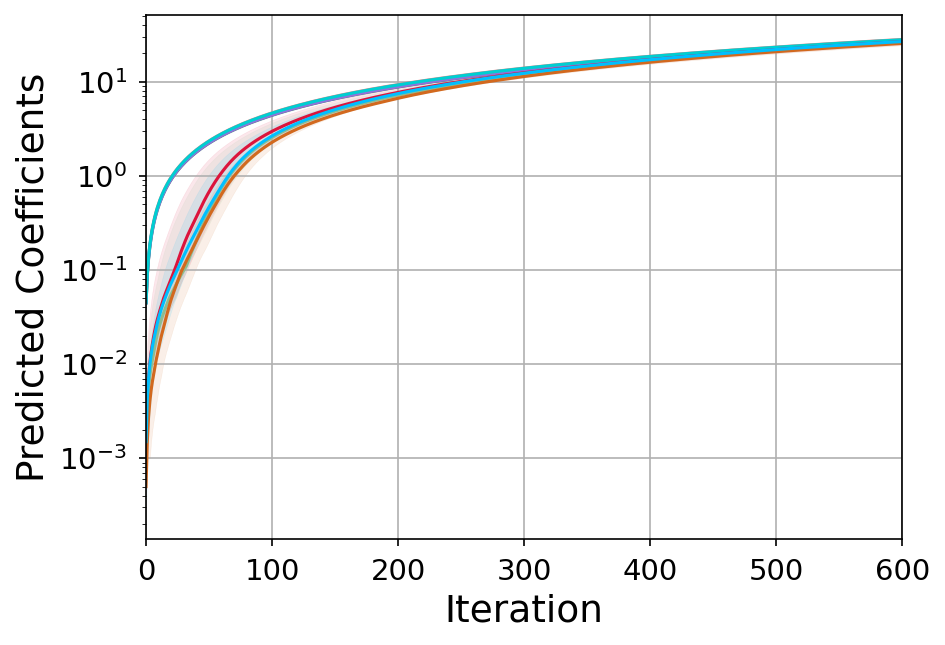

In [52]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(point_num):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[1]
        med[i][t] = sorted[2]
        maxs[i][t] = sorted[4]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i], alpha=0.1)
    plt.plot(med[i], color=col[i], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, 600)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

plt.savefig(f'figs/comparison_prediction.pdf')
plt.show()